In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import json
import sklearn 
import sklearn.decomposition
import sklearn.manifold
import numpy as np
import pandas as pd

In [2]:
fname = '../embeddings/cifar_100_davinci-001.json'
with open(fname, 'r') as f:
    embeddings = json.load(f)

In [3]:
X = np.asarray(list(embeddings.values()))

In [43]:
#pca = sklearn.manifold.TSNE(n_components=2, learning_rate='auto', init='random')
pca = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=10, n_components=2)
#pca = sklearn.decomposition.PCA(n_components=2)
transformed = pca.fit_transform(X)

In [44]:
df = pd.DataFrame(transformed)

In [45]:
df = df.rename(columns={0: "x1", 1: "x2"})

In [46]:
df

,x1,x2
0,0.096020,0.009294
1,0.103842,-0.020730
2,0.106497,0.004039
3,0.053103,-0.028654
4,0.083122,-0.027513
...,...,...
95,0.004154,0.027185
96,-0.078641,-0.107947
97,-0.050311,-0.087096
98,-0.038384,-0.085610


In [47]:
groups = 5*[0] + 5*[1] + 5*[2] + 5*[3] + 5*[4] + 5*[5] + 5*[6] + 5*[7] + 5*[8] + 5*[9] 
groups += 5*[10] + 5*[11] + 5*[12] + 5*[13] + 5*[14] + 5*[15] + 5*[16] + 5*[17] + 5*[18] + 5*[19]
names = list(embeddings.keys())


/home/chrisw/miniconda3/envs/openai/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'x2')

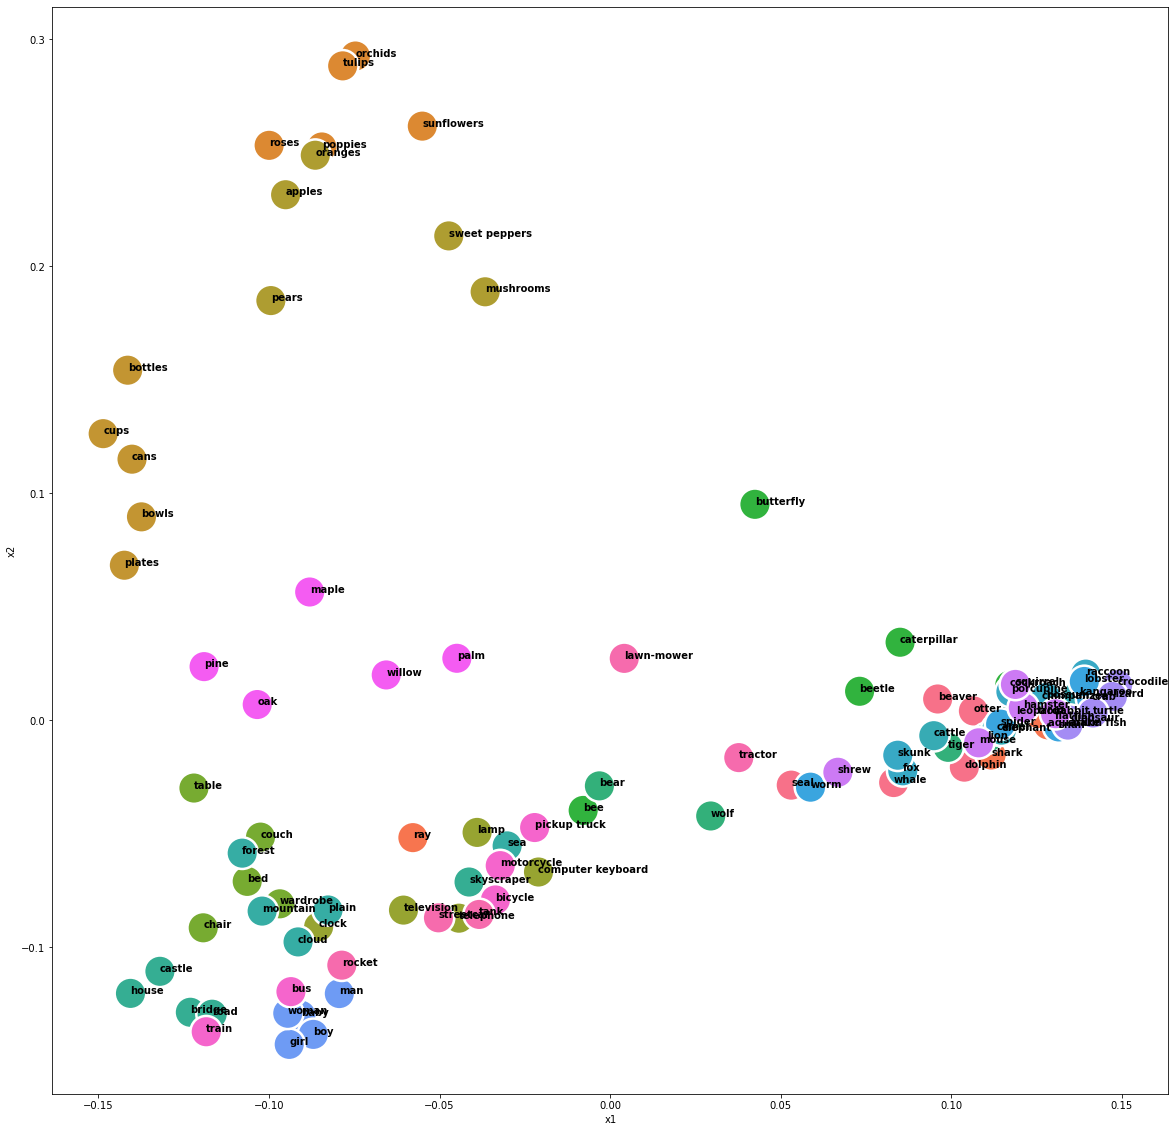

In [49]:
plt.figure(figsize=(20,20))
p1 = sns.scatterplot('x1', # Horizontal axis
       'x2', # Vertical axis
       hue=groups,
       data=df, # Data source
       legend=False, 
       s=1000,
       palette=sns.color_palette("husl", 20))  

for line in range(0,df.shape[0]):
     p1.text(df.x1[line], df.x2[line], 
     names[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

# Set x-axis label
plt.xlabel('x1')
# Set y-axis label
plt.ylabel('x2')
#plt.savefig('../results/cifar100_lle.pdf')